In [1]:
import tensorflow as tf

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range = [0.7, 1],
    rotation_range = 45,
    width_shift_range = .05,
    height_shift_range = .05
)

train_it = datagen.flow_from_directory(
    '/content/drive/My Drive/ispyscreenshots_data/data/data',
    class_mode='binary',
    batch_size=batch_size
)

val_it = datagen.flow_from_directory(
    '/content/drive/My Drive/ispyscreenshots_data/data/val',
    class_mode='binary',
    batch_size=batch_size
)

Found 5672 images belonging to 2 classes.
Found 601 images belonging to 2 classes.


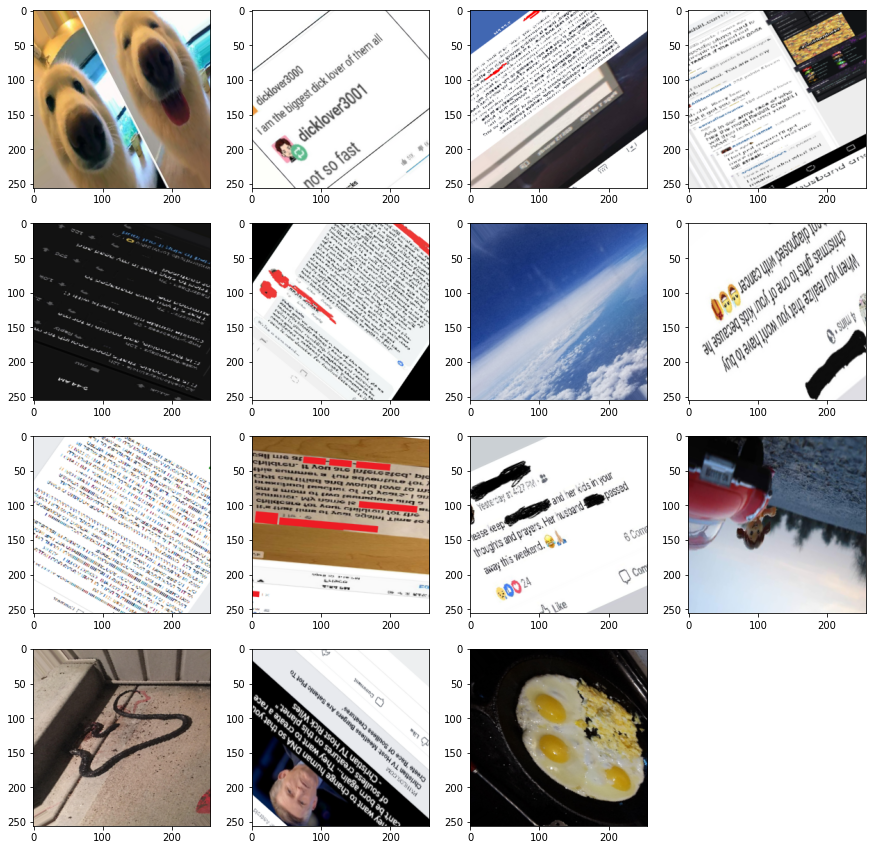

In [8]:
figsize(15, 15)
batch = train_it.next()[0]
for i in range(15):
    subplot(4, 4, i+1)
    imshow(batch[i, :, :])

In [9]:
model = tf.keras.models.load_model("/content/drive/My Drive/ispyscreenshots_ckpt/model.h5")

In [11]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Model)          (None, 5, 5, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1664)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,486,145
Non-trainable params: 158,400
_________________________________________________________________


In [18]:
old_val = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
).flow_from_directory(
    '/content/drive/My Drive/ispyscreenshots_data/data/val',
    class_mode='binary',
    batch_size=16
)

Found 601 images belonging to 2 classes.


In [103]:
old_valR = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
).flow_from_directory(
    '/content/drive/My Drive/ispyscreenshots_data/data/val',
    class_mode='binary',
    batch_size=16,
    target_size=(160, 160)
)

Found 601 images belonging to 2 classes.


In [108]:
old_valRb = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    vertical_flip=True
).flow_from_directory(
    '/content/drive/My Drive/ispyscreenshots_data/data/val',
    class_mode='binary',
    batch_size=16,
    target_size=(224, 224)
)

Found 601 images belonging to 2 classes.


In [105]:
model.evaluate(old_val)

38/38 [==============================] - 32s 854ms/step - loss: 0.1089 - accuracy: 0.9617


[0.10886178910732269, 0.961730420589447]

In [104]:
model.evaluate(old_valR)

38/38 [==============================] - 32s 846ms/step - loss: 0.1813 - accuracy: 0.9584


[0.1813330054283142, 0.9584026336669922]

In [109]:
model.evaluate(old_valRb)

38/38 [==============================] - 33s 857ms/step - loss: 0.1108 - accuracy: 0.9667


[0.11079549044370651, 0.9667221307754517]

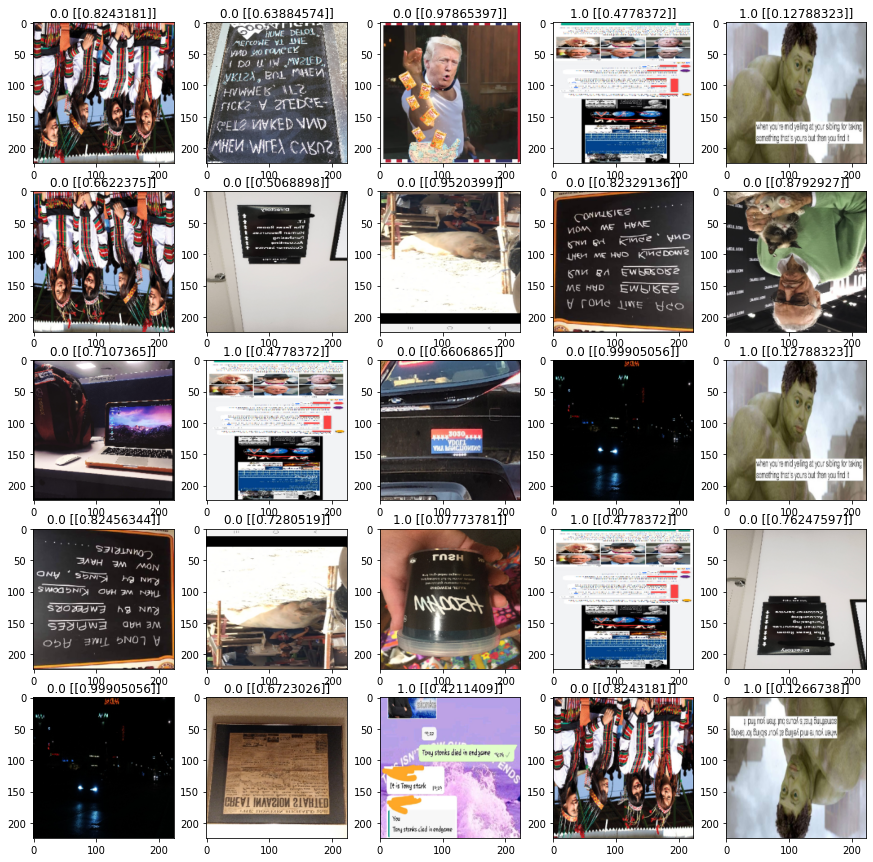

In [50]:
#Plot error samples
figsize(15, 15)
numSamples = 25
numSoFar = 0

while numSoFar < numSamples:
    batch = old_val.next()
    for i in range(8):
      i_new = tf.image.resize(batch[0][i], (224, 224))
      prediction = model.predict(np.expand_dims(i_new, 0))
      if (round(prediction[0][0]) != batch[1][i]):
        subplot(5, 5, numSoFar+1)
        imshow(i_new)
        title(str(batch[1][i]) + " " + str(prediction))
        numSoFar += 1

tf.Tensor([[0.03595935]], shape=(1, 1), dtype=float32)


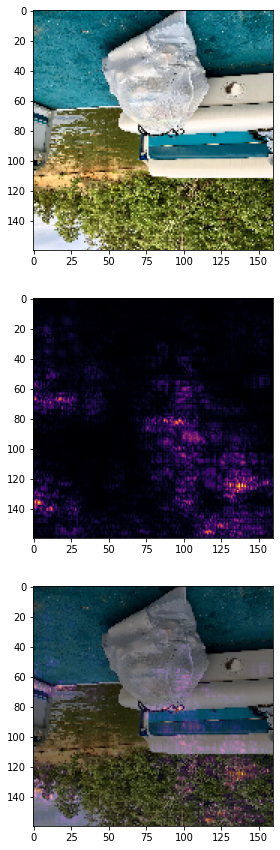

In [133]:
#Plot gradients, although perhaps integrated gradients is a better option
outTensor = model.output
inTensor = model.inputs
sample = tf.convert_to_tensor(np.expand_dims(np.array(old_valR.next()[0][0]), 0))
with tf.GradientTape() as g:
  g.watch(sample)
  pr = model(sample)
  print(pr)
outGrad = g.gradient(pr, sample)
subplot(3, 1, 1)
imshow(sample[0])
subplot(3, 1, 2)
gMap = tf.reduce_sum(tf.math.abs(outGrad[0]), axis=-1)
imshow(gMap, cmap=matplotlib.cm.inferno)
subplot(3, 1, 3)
imshow(gMap, cmap=matplotlib.cm.inferno)
imshow(sample[0], alpha=0.5)

In [76]:
np.max(outGrad)

0.001067937

In [23]:
print(old_val.next()[0][0].shape, model.input.shape, model.input_shape)

(256, 256, 3) (None, 160, 160, 3) (None, 160, 160, 3)


In [24]:
model.predict(np.expand_dims(old_val.next()[0][0], 0))

array([[0.9997793]], dtype=float32)

In [25]:
t1 = old_val.next()[0][0]

In [26]:
t2 = np.expand_dims(t1, 0)

In [111]:
b1 = old_val.next()
b2 = old_valR.next()
b3 = old_valRb.next()

In [115]:
s1 = b1[0][0]
s2 = b2[0][0]
s3 = b3[0][0]
print(s1.shape, s2.shape, s3.shape)

(256, 256, 3) (160, 160, 3) (224, 224, 3)


In [116]:
print(model.predict(np.expand_dims(s1, 0)), model.predict(np.expand_dims(s2, 0)), model.predict(np.expand_dims(s3, 0)))

[[0.01392982]] [[0.9999964]] [[0.9999521]]


In [129]:
model.predict(np.zeros((1, 256, 256, 3)))

array([[0.03957554]], dtype=float32)